# Simplified detection of urban types

Example adapted from the [SDSC 2021 Workshop](https://github.com/martinfleis/sdsc21-workshop) led by Martin Fleischmann. You can see the recording of the workshop on [YouTube](https://www.youtube.com/watch?v=itUX56Ks1UE).

This example illustrates the potential of morphometrics captured by `momepy` in capturing the structure of cities. We will pick a town, fetch its data from the OpenStreetMap, and analyse it to detect individual types of urban structure within it.

This method is only illustrative and is based on the more extensive one published by Fleischmann et al. (2021) available from [https://github.com/martinfleis/numerical-taxonomy-paper](https://github.com/martinfleis/numerical-taxonomy-paper).

> Fleischmann M, Feliciotti A, Romice O and Porta S (2021) Methodological Foundation of a Numerical Taxonomy of Urban Form. Environment and Planning B: Urban Analytics and City Science, doi: 10.1177/23998083211059835

It depends on the following packages:

```
- momepy
- osmnx
- clustergram
- bokeh
- scikit-learn
- geopy
- ipywidgets
```


In [1]:
import warnings

import geopandas
import libpysal
import momepy
import osmnx
import pandas

from clustergram import Clustergram

import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.plotting import show

output_notebook()

Loading BokehJS ...

Pick a place, ideally a town with a good coverage in OpenStreetMap and its local CRS.

In [2]:
place = 'Znojmo, Czechia'
local_crs = 5514

We can interactively explore the place we just selected.

In [3]:
geopandas.tools.geocode(place).explore()

## Input data

We can use ``OSMnx`` to quickly download data from OpenStreetMap. If you intend to download larger areas, we recommend using ``pyrosm`` instead.

### Buildings

In [4]:
buildings = osmnx.geometries.geometries_from_place(place, tags={'building':True})
buildings.head()

amenity            name wheelchair  \
element_type osmid                                                     
node         3749294087  place_of_worship             NaN        NaN   
             4756492121  place_of_worship             NaN        NaN   
             6898265457               NaN             NaN        NaN   
way          50293678    place_of_worship     sv. Antonín        NaN   
             50293682    place_of_worship  Eliášova kaple        NaN   

                                                                  geometry  \
element_type osmid                                                           
node         3749294087                          POINT (16.04696 48.85305)   
             4756492121                          POINT (16.02817 48.83953)   
             6898265457                          POINT (16.01186 48.85677)   
way          50293678    POLYGON ((16.03814 48.85812, 16.03814 48.85814...   
             50293682    POLYGON ((16.03830 48.85657, 16.03833 48.85659...   

                        tourism brand brand:wikidata brand:wikipedia operator  \
element_type osmid                                                              
node         3749294087     NaN   NaN            NaN             NaN      NaN   
             4756492121     NaN   NaN            NaN             NaN      NaN   
             6898265457     NaN   NaN            NaN             NaN      NaN   
way          50293678       NaN   NaN            NaN             NaN      NaN   
             50293682       NaN   NaN            NaN             NaN      NaN   

                        operator:wikidata  ... location voltage source_1  \
element_type osmid                         ...                             
node         3749294087               NaN  ...      NaN     NaN      NaN   
             4756492121               NaN  ...      NaN     NaN      NaN   
             6898265457               NaN  ...      NaN     NaN      NaN   
way          50293678                 NaN  ...      NaN     NaN      NaN   
             50293682                 NaN  ...      NaN     NaN      NaN   

                        pillbox name:signed building:part  ref ways type  \
element_type osmid                                                         
node         3749294087     NaN         NaN           NaN  NaN  NaN  NaN   
             4756492121     NaN         NaN           NaN  NaN  NaN  NaN   
             6898265457     NaN         NaN           NaN  NaN  NaN  NaN   
way          50293678       NaN         NaN           NaN  NaN  NaN  NaN   
             50293682       NaN         NaN           NaN  NaN  NaN  NaN   

                        emergency  
element_type osmid                 
node         3749294087       NaN  
             4756492121       NaN  
             6898265457       NaN  
way          50293678         NaN  
             50293682         NaN  

[5 rows x 104 columns]

The OSM input may need a bit of cleaning to ensure only proper polygons are kept.

In [5]:
buildings.geom_type.value_counts()

Polygon    12142
Point          3
dtype: int64

In [6]:
buildings = buildings[buildings.geom_type == "Polygon"].reset_index(drop=True)

And we should re-project the data from WGS84 to the local projection in meters (momepy default values assume meters not feet or degrees). We will also drop unnecessary columns.

In [7]:
buildings = buildings[["geometry"]].to_crs(local_crs)

Finally, we can assign unique ID to each row.

In [8]:
buildings["uID"] = range(len(buildings))
buildings.head()

geometry  uID
0  POLYGON ((-643743.474 -1193358.749, -643743.30...    0
1  POLYGON ((-643751.446 -1193530.633, -643749.37...    1
2  POLYGON ((-643281.601 -1193130.831, -643283.76...    2
3  POLYGON ((-643381.904 -1193174.697, -643388.48...    3
4  POLYGON ((-643370.450 -1193130.215, -643398.26...    4

### Streets

Similar operations are done with streets.

In [9]:
osm_graph = osmnx.graph_from_place(place, network_type='drive')
osm_graph = osmnx.projection.project_graph(osm_graph, to_crs=local_crs)
streets = osmnx.graph_to_gdfs(
    osm_graph, 
    nodes=False, 
    edges=True,
    node_geometry=False, 
    fill_edge_geometry=True
)

In [10]:
streets.head()

osmid  ref        name      highway  oneway  \
u         v          key                                                   
74103628  639231391  0    33733060  361  Přímětická    secondary   False   
          3775990798 0    33733060  361  Přímětická    secondary   False   
639231391 74103628   0    33733060  361  Přímětická    secondary   False   
          74142638   0    33733060  361  Přímětická    secondary   False   
          639231314  0    50313241  NaN  Mičurinova  residential    True   

                         reversed   length  \
u         v          key                     
74103628  639231391  0      False   24.574   
          3775990798 0       True   60.354   
639231391 74103628   0       True   24.574   
          74142638   0      False   54.260   
          639231314  0      False  101.376   

                                                                   geometry  \
u         v          key                                                      
74103628  639231391  0    LINESTRING (-643239.057 -1192850.232, -643229....   
          3775990798 0    LINESTRING (-643239.057 -1192850.232, -643241....   
639231391 74103628   0    LINESTRING (-643229.639 -1192872.949, -643239....   
          74142638   0    LINESTRING (-643229.639 -1192872.949, -643219....   
          639231314  0    LINESTRING (-643229.639 -1192872.949, -643233....   

                         maxspeed lanes bridge junction width tunnel access  
u         v          key                                                     
74103628  639231391  0        NaN   NaN    NaN      NaN   NaN    NaN    NaN  
          3775990798 0        NaN   NaN    NaN      NaN   NaN    NaN    NaN  
639231391 74103628   0        NaN   NaN    NaN      NaN   NaN    NaN    NaN  
          74142638   0        NaN   NaN    NaN      NaN   NaN    NaN    NaN  
          639231314  0        NaN   NaN    NaN      NaN   NaN    NaN    NaN

We can also do some preprocessing using momepy to ensure we have proper network topology.

In [11]:
streets = momepy.remove_false_nodes(streets)
streets = streets[["geometry"]]
streets["nID"] = range(len(streets))

In [12]:
streets.head()

geometry  nID
0  LINESTRING (-643239.057 -1192850.232, -643229....    0
1  LINESTRING (-643239.057 -1192850.232, -643241....    1
2  LINESTRING (-643229.639 -1192872.949, -643239....    2
3  LINESTRING (-643229.639 -1192872.949, -643219....    3
4  LINESTRING (-643229.639 -1192872.949, -643233....    4

## Generated data

### Tessellation

Given building footprints:

![blg](http://docs.momepy.org/en/stable/_images/user_guide_elements_tessellation_3_0.png)

We can generate a spatial unit using morphological tessellation:

![tess](http://docs.momepy.org/en/stable/_images/user_guide_elements_tessellation_14_0.png)

In [13]:
limit = momepy.buffered_limit(buildings, 100)

tessellation = momepy.Tessellation(buildings, "uID", limit, verbose=False, segment=1)
tessellation = tessellation.tessellation

/Users/martin/mambaforge/envs/stable/lib/python3.10/site-packages/momepy/elements.py:384: UserWarning: Tessellation does not fully match buildings. 22 element(s) collapsed during generation - unique_id: {4226, 11400, 4234, 4237, 3988, 3998, 4264, 4267, 4271, 4272, 4276, 4277, 9156, 10827, 10828, 8662, 11620, 11621, 9191, 11628, 4078, 10606}
  warnings.warn(
/Users/martin/mambaforge/envs/stable/lib/python3.10/site-packages/momepy/elements.py:395: UserWarning: Tessellation contains MultiPolygon elements. Initial objects should be edited. unique_id of affected elements: [10011, 9841, 4216, 3255, 11933, 3201, 11139]
  warnings.warn(


### Link streets

Link unique IDs of streets to buildings and tessellation cells based on the nearest neighbor join.

In [14]:
buildings = buildings.sjoin_nearest(streets, max_distance=1000, how="left")
buildings.head()

geometry  uID  index_right     nID
0  POLYGON ((-643743.474 -1193358.749, -643743.30...    0       1060.0  1060.0
0  POLYGON ((-643743.474 -1193358.749, -643743.30...    0       1061.0  1061.0
1  POLYGON ((-643751.446 -1193530.633, -643749.37...    1       1478.0  1478.0
2  POLYGON ((-643281.601 -1193130.831, -643283.76...    2        898.0   898.0
2  POLYGON ((-643281.601 -1193130.831, -643283.76...    2        243.0   243.0

Clean duplicates and attach the network ID to the tessellation as well.

In [15]:
buildings = buildings.drop_duplicates("uID").drop(columns="index_right")
tessellation = tessellation.merge(buildings[['uID', 'nID']], on='uID', how='left')

## Measure

Measure individual morphometric characters. For details see the User Guide and the API reference.

### Dimensions

In [16]:
buildings["area"] = buildings.area
tessellation["area"] = tessellation.area
streets["length"] = streets.length

### Shape

In [17]:
buildings['eri'] = momepy.EquivalentRectangularIndex(buildings).series
buildings['elongation'] = momepy.Elongation(buildings).series
tessellation['convexity'] = momepy.Convexity(tessellation).series
streets["linearity"] = momepy.Linearity(streets).series

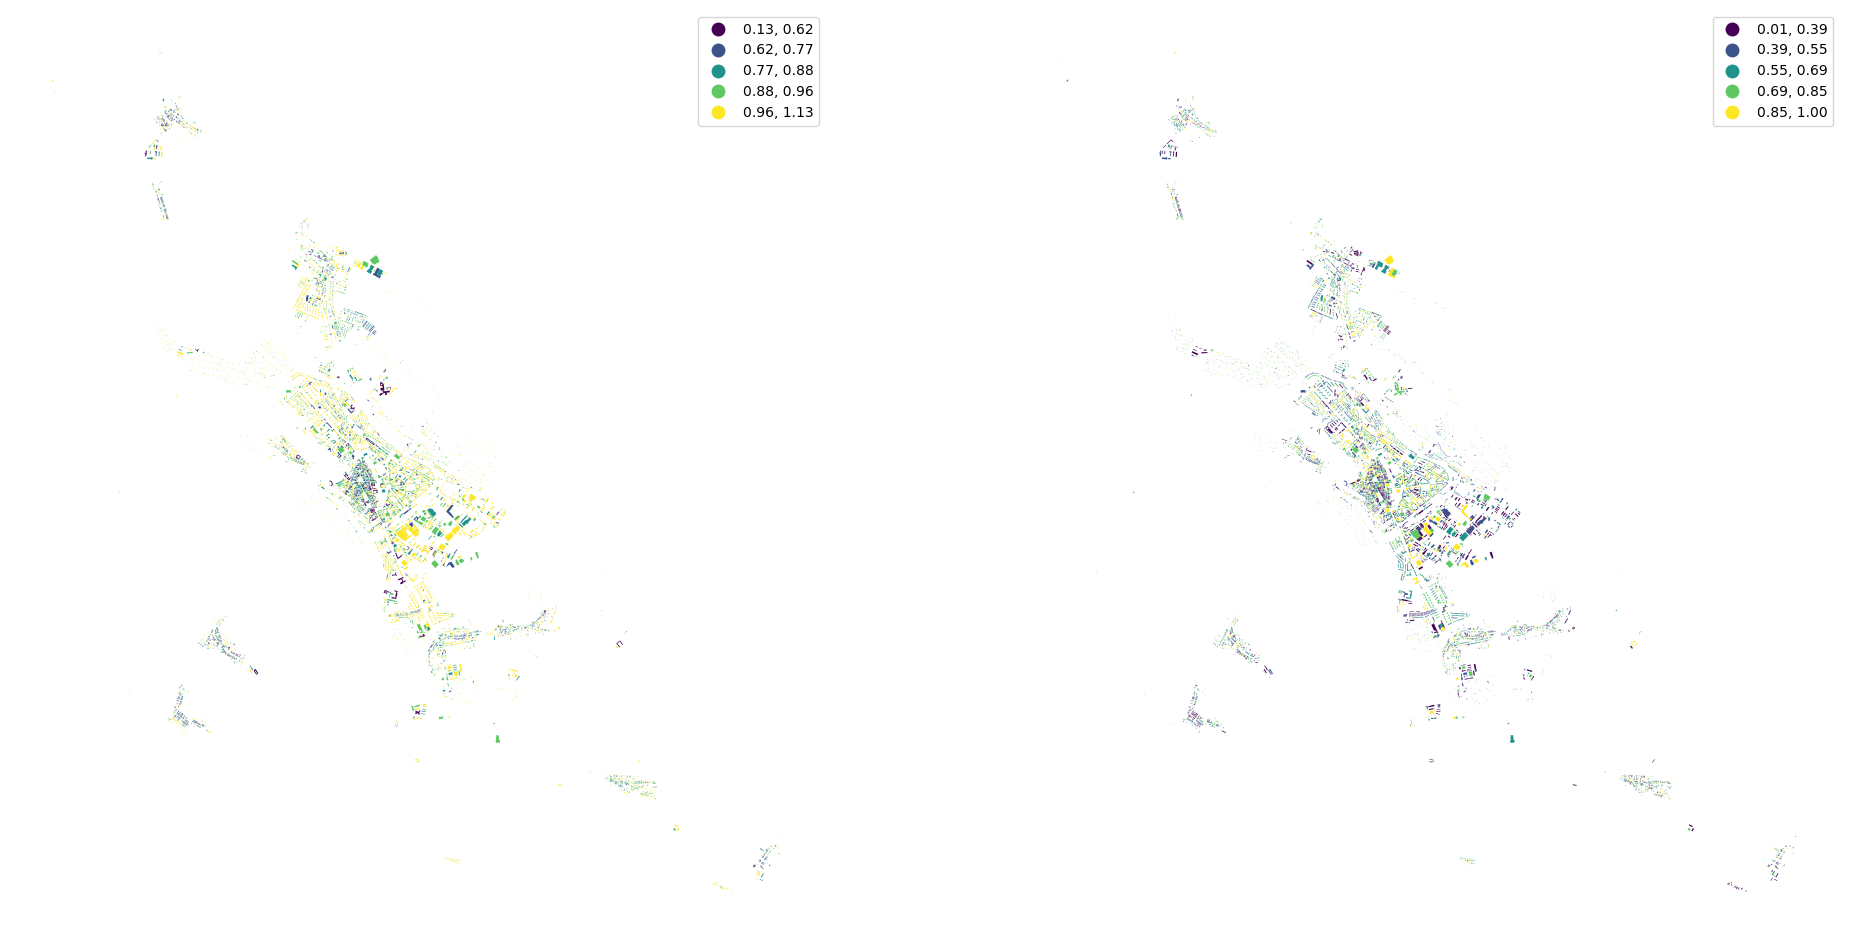

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("eri", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("elongation", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

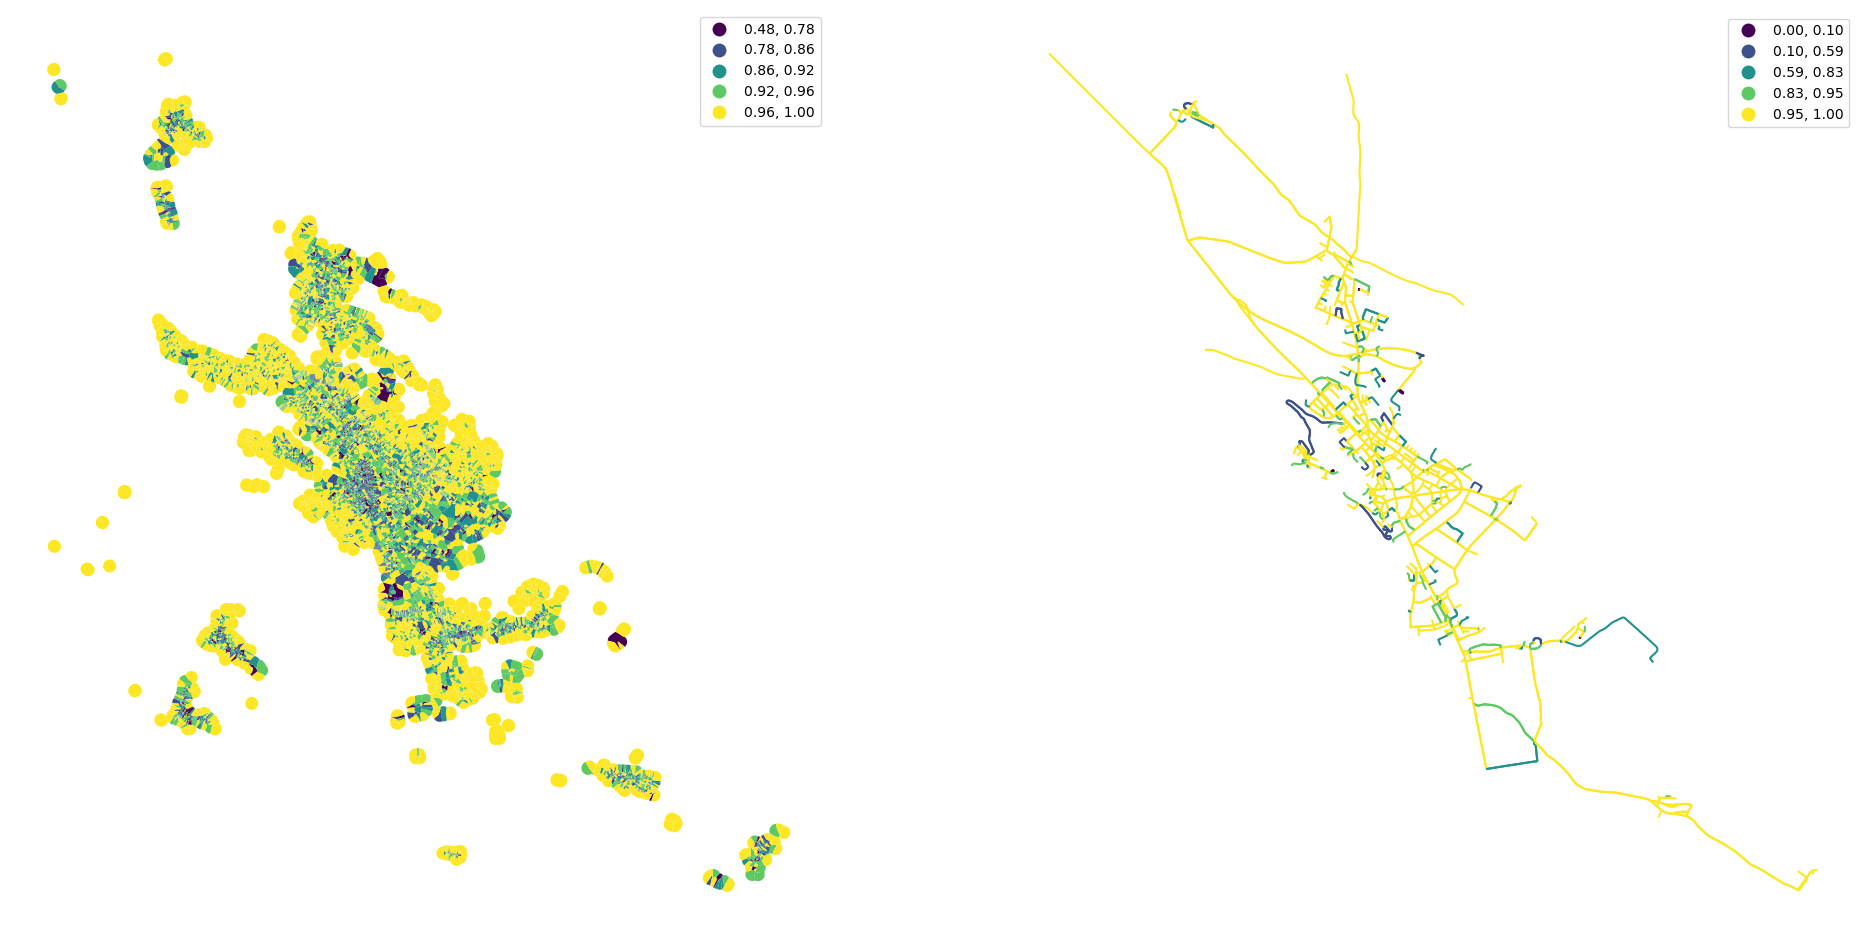

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("linearity", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

### Spatial distribution

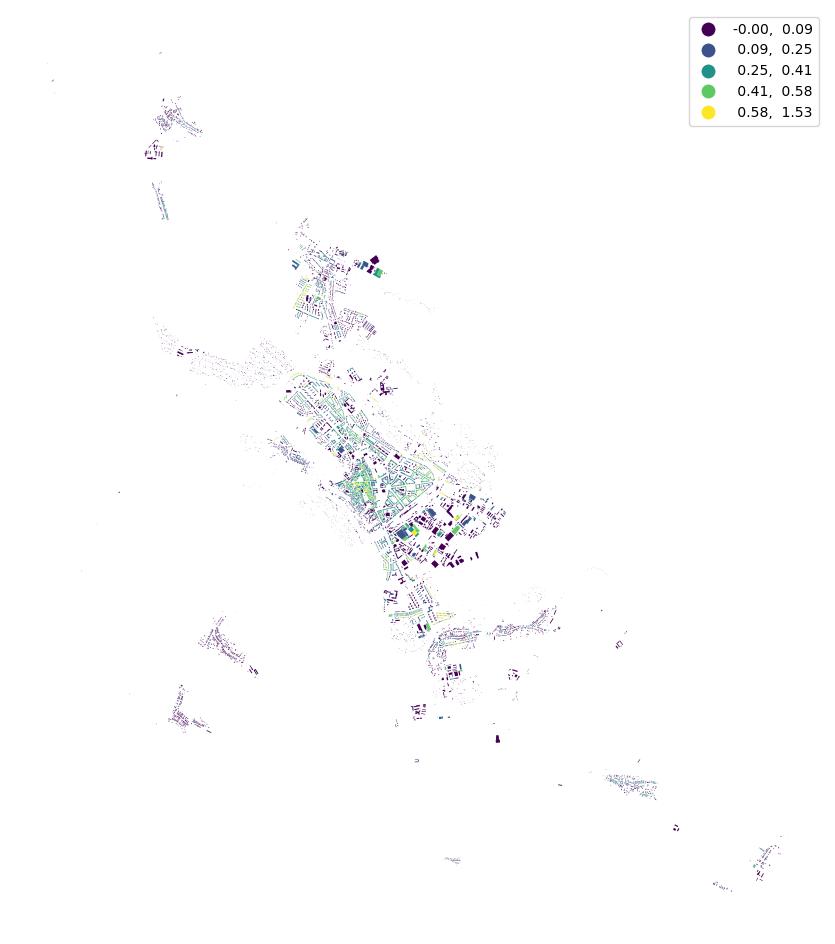

In [20]:
buildings["shared_walls"] = momepy.SharedWallsRatio(buildings).series
buildings.plot("shared_walls", figsize=(12, 12), scheme="natural_breaks", legend=True).set_axis_off()

Generate spatial weights matrix using `libpysal`.

In [21]:
queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tessellation, ids="uID", silence_warnings=True)

In [22]:
tessellation["neighbors"] = momepy.Neighbors(tessellation, queen_1, "uID", weighted=True, verbose=False).series
tessellation["covered_area"] = momepy.CoveredArea(tessellation, queen_1, "uID", verbose=False).series

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    buildings["neighbor_distance"] = momepy.NeighborDistance(buildings, queen_1, "uID", verbose=False).series

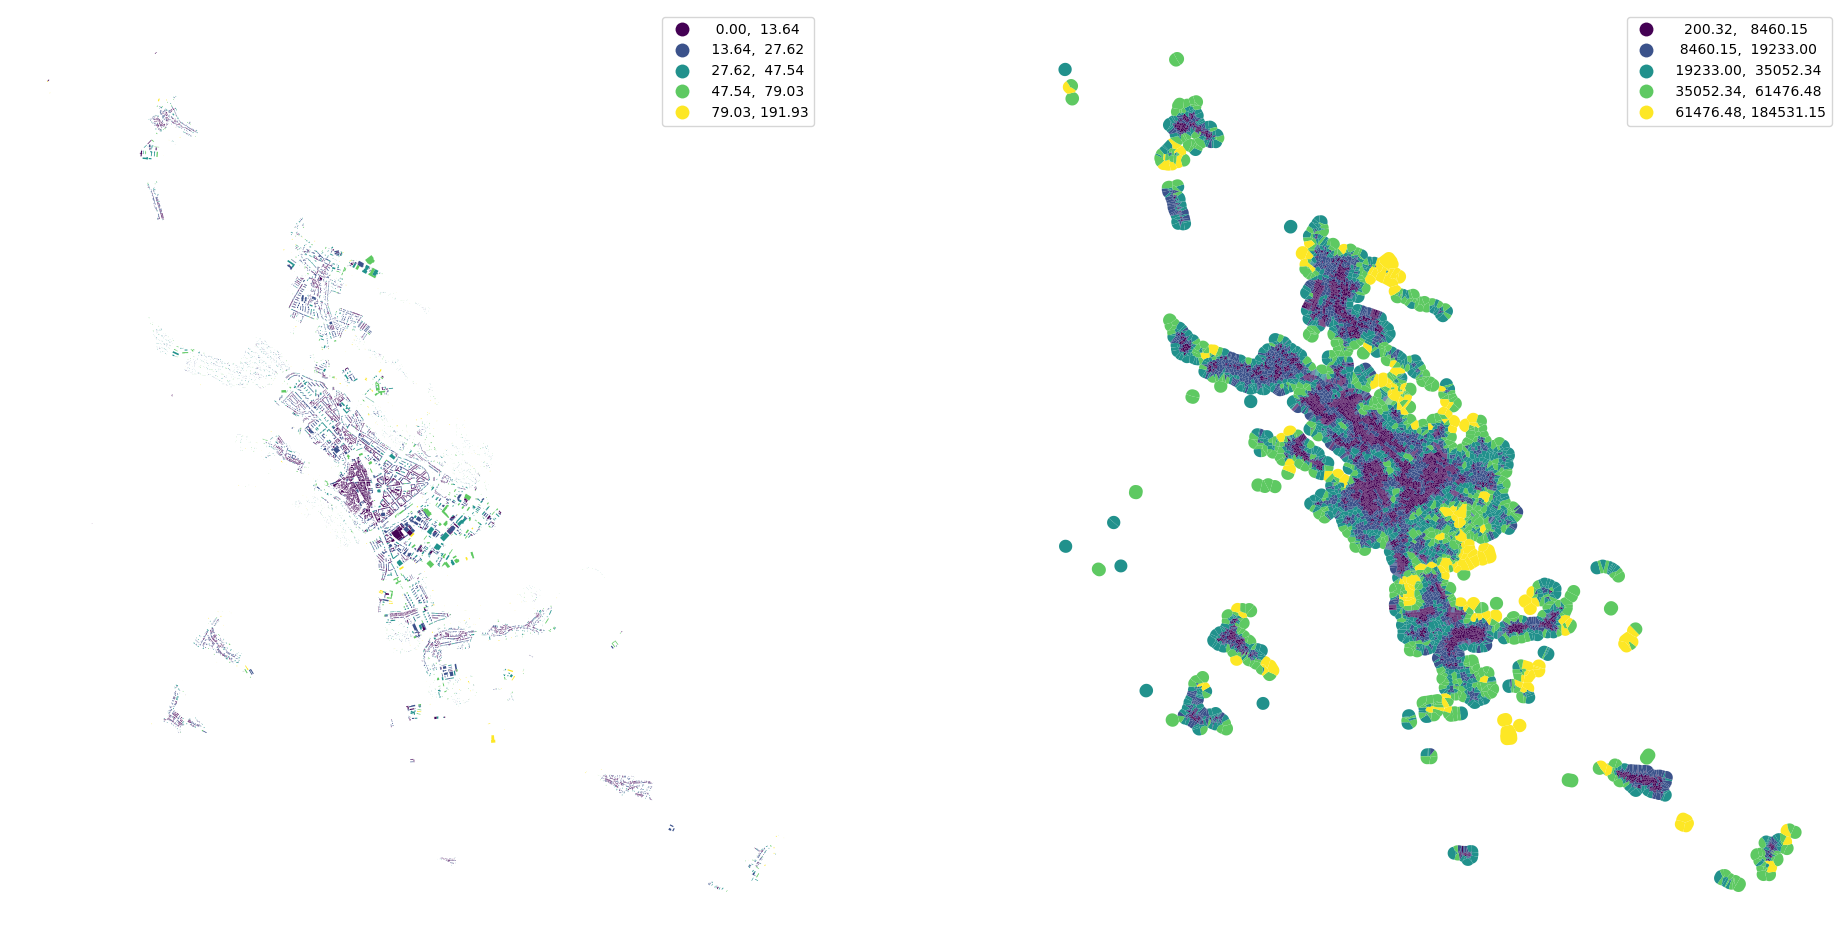

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("neighbor_distance", ax=ax[0], scheme="natural_breaks", legend=True)
tessellation.plot("covered_area", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [24]:
queen_3 = momepy.sw_high(k=3, weights=queen_1)
buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)

buildings['interbuilding_distance'] = momepy.MeanInterbuildingDistance(buildings, queen_1, 'uID', queen_3, verbose=False).series
buildings['adjacency'] = momepy.BuildingAdjacency(buildings, queen_3, 'uID', buildings_q1, verbose=False).series

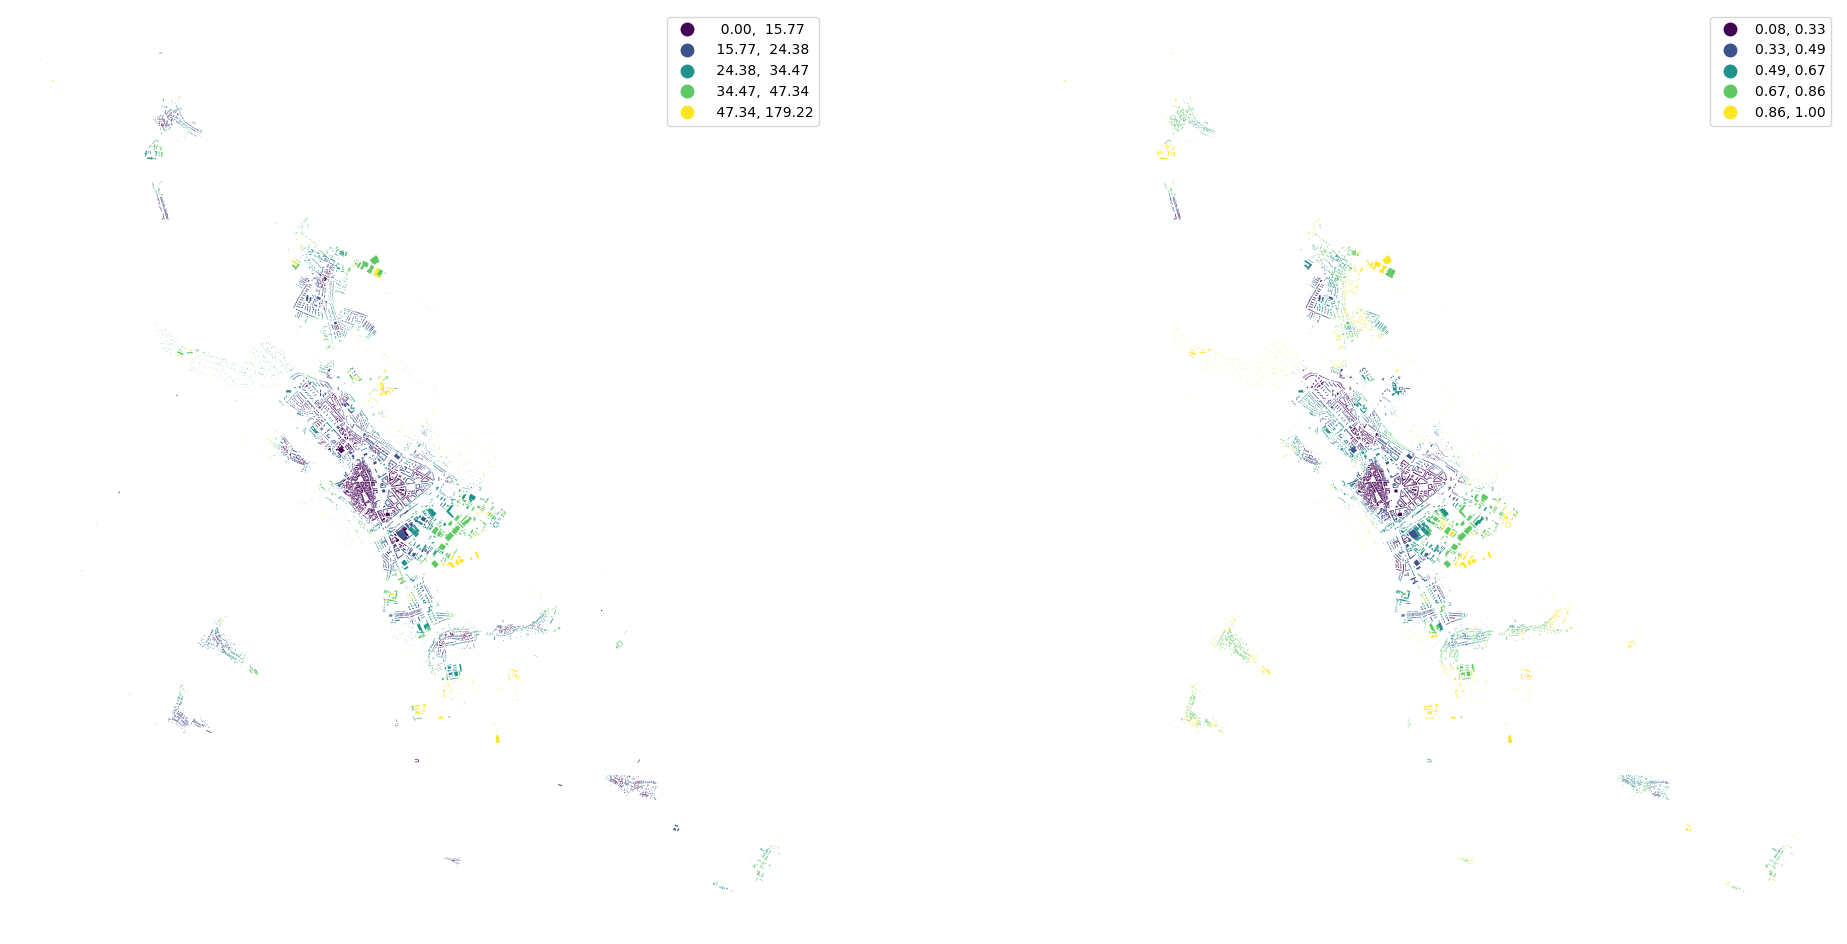

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("interbuilding_distance", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("adjacency", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [26]:
profile = momepy.StreetProfile(streets, buildings)
streets["width"] = profile.w
streets["width_deviation"] = profile.wd
streets["openness"] = profile.o

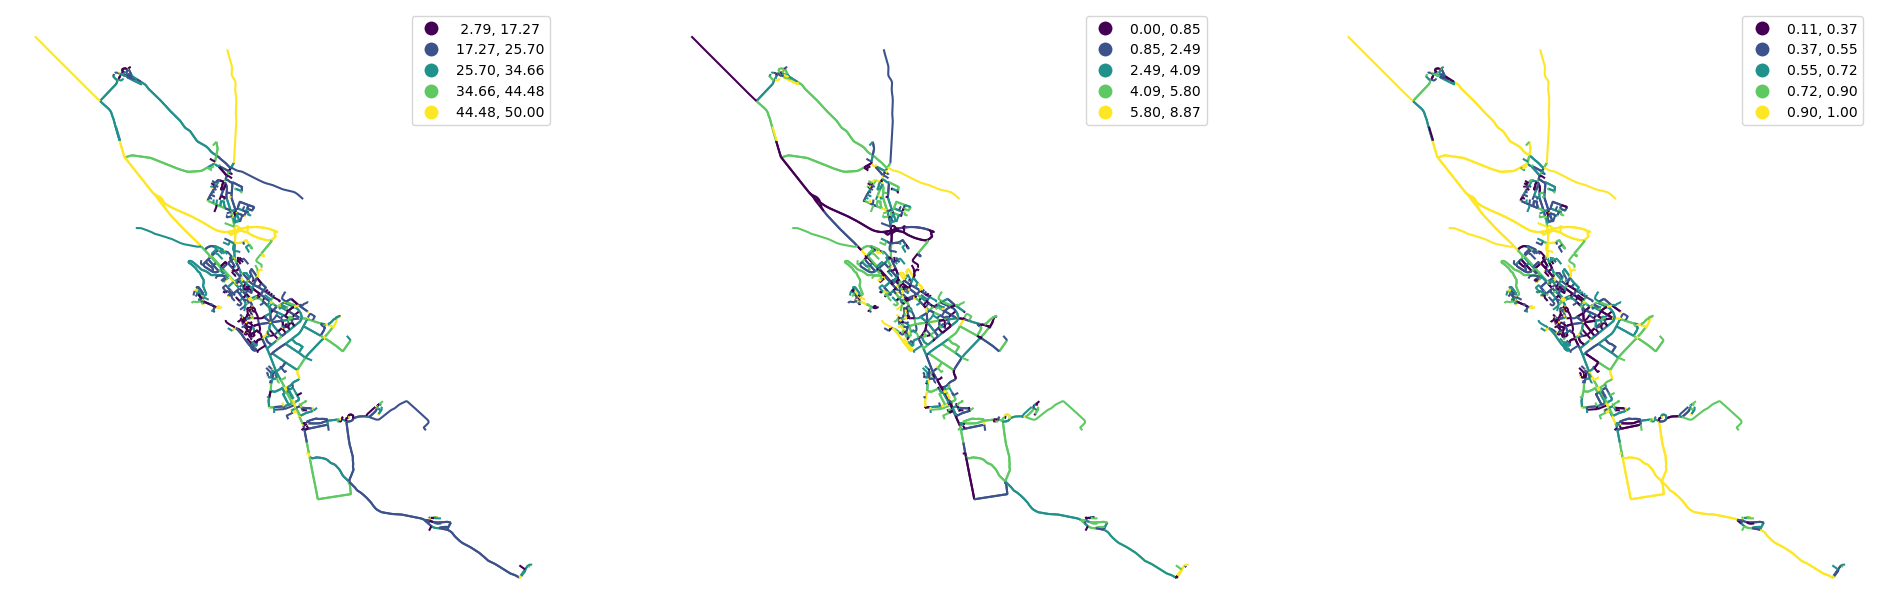

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

streets.plot("width", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("width_deviation", ax=ax[1], scheme="natural_breaks", legend=True)
streets.plot("openness", ax=ax[2], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

### Intensity

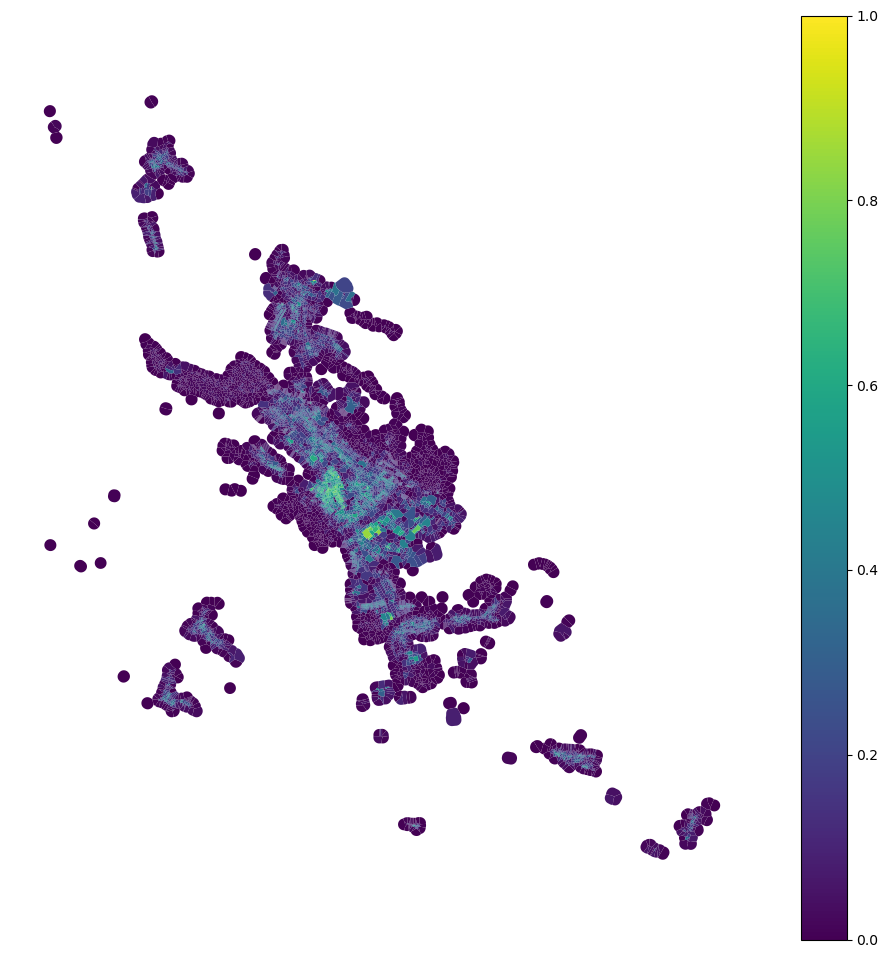

In [28]:
tessellation['car'] = momepy.AreaRatio(tessellation, buildings, 'area', 'area', 'uID').series
tessellation.plot("car", figsize=(12, 12), vmin=0, vmax=1, legend=True).set_axis_off()

### Connectivity

In [29]:
graph = momepy.gdf_to_nx(streets)
graph = momepy.node_degree(graph)
graph = momepy.closeness_centrality(graph, radius=400, distance="mm_len")
graph = momepy.meshedness(graph, radius=400, distance="mm_len")
nodes, streets = momepy.nx_to_gdf(graph)

  0%|          | 0/766 [00:00<?, ?it/s]

  0%|          | 0/766 [00:00<?, ?it/s]

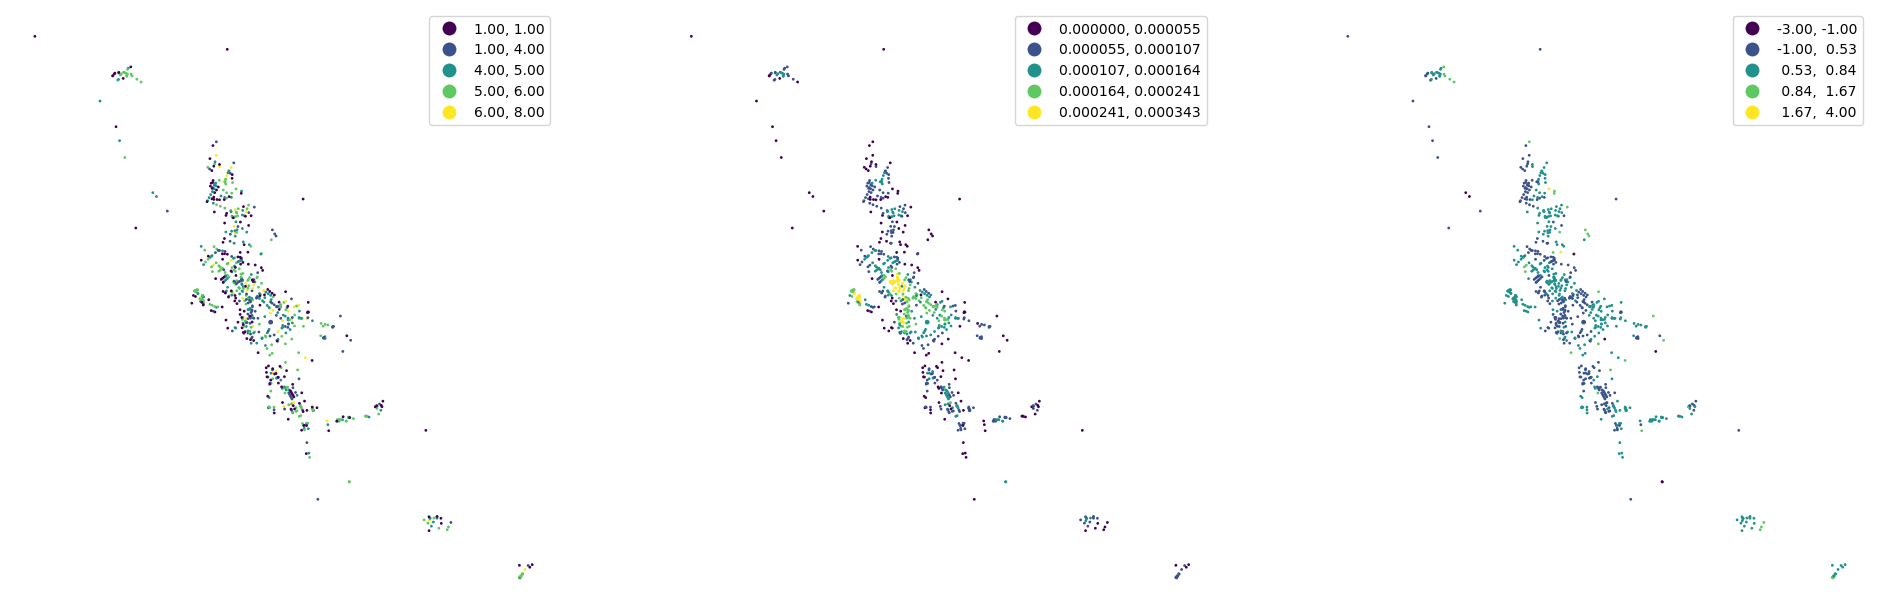

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

nodes.plot("degree", ax=ax[0], scheme="natural_breaks", legend=True, markersize=1)
nodes.plot("closeness", ax=ax[1], scheme="natural_breaks", legend=True, markersize=1, legend_kwds={"fmt": "{:.6f}"})
nodes.plot("meshedness", ax=ax[2], scheme="natural_breaks", legend=True, markersize=1)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

In [31]:
buildings["nodeID"] = momepy.get_node_id(buildings, nodes, streets, "nodeID", "nID")

  0%|          | 0/12142 [00:00<?, ?it/s]

Link all data together (to tessellation cells or buildings).

In [32]:
tessellation.head()

uID                                           geometry     nID  \
0   5438  POLYGON ((-637358.313 -1200006.277, -637357.92...   643.0   
1   5403  POLYGON ((-636871.053 -1199819.853, -636871.45...   642.0   
2  10611  POLYGON ((-637462.192 -1199942.387, -637450.89...   643.0   
3   5437  POLYGON ((-636574.691 -1199444.622, -636572.80...  1629.0   
4  10617  POLYGON ((-637599.665 -1199909.097, -637595.79...   636.0   

           area  convexity  neighbors  covered_area       car  
0  27736.670898   0.995293   0.003108  41793.250296  0.007476  
1  19855.193192   0.942935   0.005466  56679.209969  0.022276  
2   5980.537480   0.900015   0.006719  23484.755027  0.066270  
3  18362.214059   0.988620   0.003802  42309.584227  0.005690  
4   6221.647571   0.829355   0.010157  43342.518118  0.049808

In [33]:
merged = tessellation.merge(buildings.drop(columns=['nID', 'geometry']), on='uID')
merged = merged.merge(streets.drop(columns='geometry'), on='nID', how='left')
merged = merged.merge(nodes.drop(columns='geometry'), on='nodeID', how='left')

In [34]:
merged.columns

Index(['uID', 'geometry', 'nID', 'area_x', 'convexity', 'neighbors',
       'covered_area', 'car', 'area_y', 'eri', 'elongation', 'shared_walls',
       'neighbor_distance', 'interbuilding_distance', 'adjacency', 'nodeID',
       'length', 'linearity', 'width', 'width_deviation', 'openness', 'mm_len',
       'node_start', 'node_end', 'degree', 'closeness', 'meshedness'],
      dtype='object')

## Understanding the context

Measure first, second and third quartile of distribution of values within an area around each building.

In [35]:
percentiles = []
for column in merged.columns.drop(["uID", "nodeID", "nID", 'mm_len', 'node_start', 'node_end', "geometry"]):
    perc = momepy.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
    perc.columns = [f"{column}_" + str(x) for x in perc.columns]
    percentiles.append(perc)

In [36]:
percentiles_joined = pandas.concat(percentiles, axis=1)
percentiles_joined.head()

area_x_25    area_x_50    area_x_75  convexity_25  convexity_50  \
0  7151.505440  8460.534526  9102.552267      0.874500      0.888902   
1  2635.809199  3979.104339  7912.110750      0.906751      0.943435   
2  4869.281367  6119.443335  9102.552267      0.874500      0.947803   
3   774.500023  2527.511720  9756.635411      0.841715      0.946898   
4  5615.435876  6119.443335  8460.534526      0.888902      0.947803   

   convexity_75  neighbors_25  neighbors_50  neighbors_75  covered_area_25  \
0      0.929755      0.006852      0.007068      0.007307     38509.340860   
1      0.980033      0.012226      0.021552      0.027465     34791.666675   
2      0.971754      0.007068      0.008105      0.009836     28474.090836   
3      0.979633      0.012229      0.026525      0.032112     10886.683093   
4      0.971754      0.007598      0.008616      0.009836     27790.702394   

   ...  openness_75  degree_25  degree_50  degree_75  closeness_25  \
0  ...     0.954774        6.0        6.0        6.0      0.000088   
1  ...     1.000000        4.0        6.0        6.0      0.000095   
2  ...     0.954774        6.0        6.0        6.0      0.000088   
3  ...     0.611111        1.0        4.0        7.0      0.000050   
4  ...     0.954774        6.0        6.0        6.0      0.000088   

   closeness_50  closeness_75  meshedness_25  meshedness_50  meshedness_75  
0      0.000088      0.000088       0.894737       0.894737       0.894737  
1      0.000095      0.000097       0.809524       0.894737       1.000000  
2      0.000088      0.000088       0.894737       0.894737       0.894737  
3      0.000064      0.000088       0.736842       0.809524       0.809524  
4      0.000088      0.000088       0.894737       0.894737       0.894737  

[5 rows x 60 columns]

See the difference between original convexity and spatially lagged one.

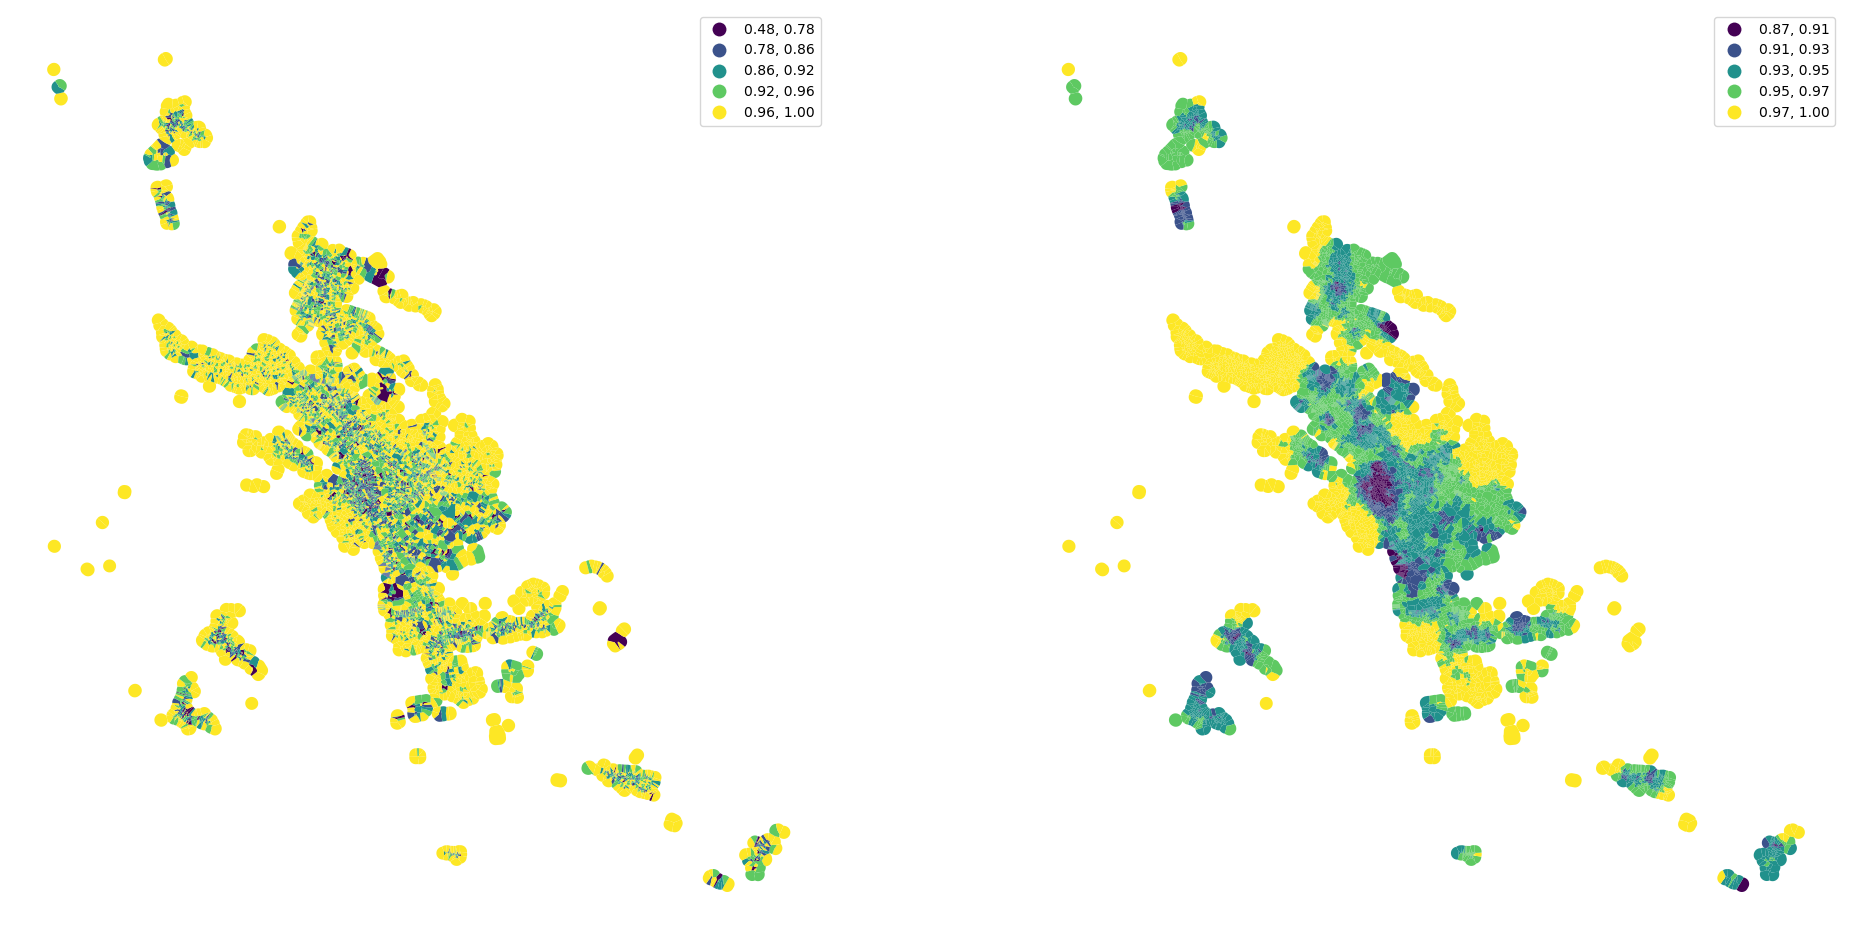

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
merged.plot(percentiles_joined['convexity_50'].values, ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

## Clustering

Now we can use obtained values within a cluster analysis that should detect types of urban structure.

Standardize values before clustering.

In [38]:
standardized = (percentiles_joined - percentiles_joined.mean()) / percentiles_joined.std()
standardized.head()

area_x_25  area_x_50  area_x_75  convexity_25  convexity_50  convexity_75  \
0   4.012293   3.822016   2.471317     -1.150505     -2.937437     -3.738588   
1   1.227141   1.481257   2.041643     -0.178249     -0.333977      0.414913   
2   2.604682   2.599208   2.471317     -1.150505     -0.125426     -0.269075   
3   0.079138   0.723055   2.707400     -2.138892     -0.168624      0.381826   
4   3.064889   2.599208   2.239589     -0.716326     -0.125426     -0.269075   

   neighbors_25  neighbors_50  neighbors_75  covered_area_25  ...  \
0     -2.123246     -2.290866     -2.293068         4.396423  ...   
1     -1.731303     -1.481919     -1.470683         3.874907  ...   
2     -2.107520     -2.232961     -2.189909         2.988675  ...   
3     -1.731108     -1.204135     -1.281096         0.521508  ...   
4     -2.068847     -2.204418     -2.189909         2.892809  ...   

   openness_75  degree_25  degree_50  degree_75  closeness_25  closeness_50  \
0     1.562824   1.166541   0.764997   0.395451      0.261291      0.004195   
1     1.791297   0.127987   0.764997   0.395451      0.372816      0.105592   
2     1.562824   1.166541   0.764997   0.395451      0.261291      0.004195   
3    -0.173292  -1.429845  -0.356271   1.016309     -0.397190     -0.375620   
4     1.562824   1.166541   0.764997   0.395451      0.261291      0.004195   

   closeness_75  meshedness_25  meshedness_50  meshedness_75  
0     -0.217062       1.466698       1.306208       0.758225  
1     -0.088609       1.137685       1.306208       1.072073  
2     -0.217062       1.466698       1.306208       0.758225  
3     -0.222128       0.857056       0.963601       0.504157  
4     -0.217062       1.466698       1.306208       0.758225  

[5 rows x 60 columns]

### How many clusters?

To determine how many clusters we should aim for, we can use a little package called `clustergram`. See its [documentation](https://clustergram.readthedocs.io) for details.

In [39]:
cgram = Clustergram(range(1, 12), n_init=10, random_state=42)
cgram.fit(standardized.fillna(0))

show(cgram.bokeh())

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.09465193748474121 seconds.
K=3 fitted in 0.2078840732574463 seconds.
K=4 fitted in 0.15575194358825684 seconds.
K=5 fitted in 0.2045137882232666 seconds.
K=6 fitted in 0.20878005027770996 seconds.
K=7 fitted in 0.27375102043151855 seconds.
K=8 fitted in 0.29180908203125 seconds.
K=9 fitted in 0.43022894859313965 seconds.
K=10 fitted in 0.2906839847564697 seconds.
K=11 fitted in 0.5263171195983887 seconds.


/Users/martin/mambaforge/envs/stable/lib/python3.10/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


Clustegram gives us also the final labels. (Normally, you would run the final clustering on much larger number of initialisations.)

In [40]:
cgram.labels.head()

1   2   3   4   5   6   7   8   9   10  11
0   0   1   0   2   2   0   6   2   8   2   5
1   0   1   0   2   2   0   6   2   8   2   5
2   0   1   0   2   2   0   6   2   8   2   5
3   0   1   2   1   4   2   2   5   7   1   0
4   0   1   0   2   2   0   6   2   8   2   5

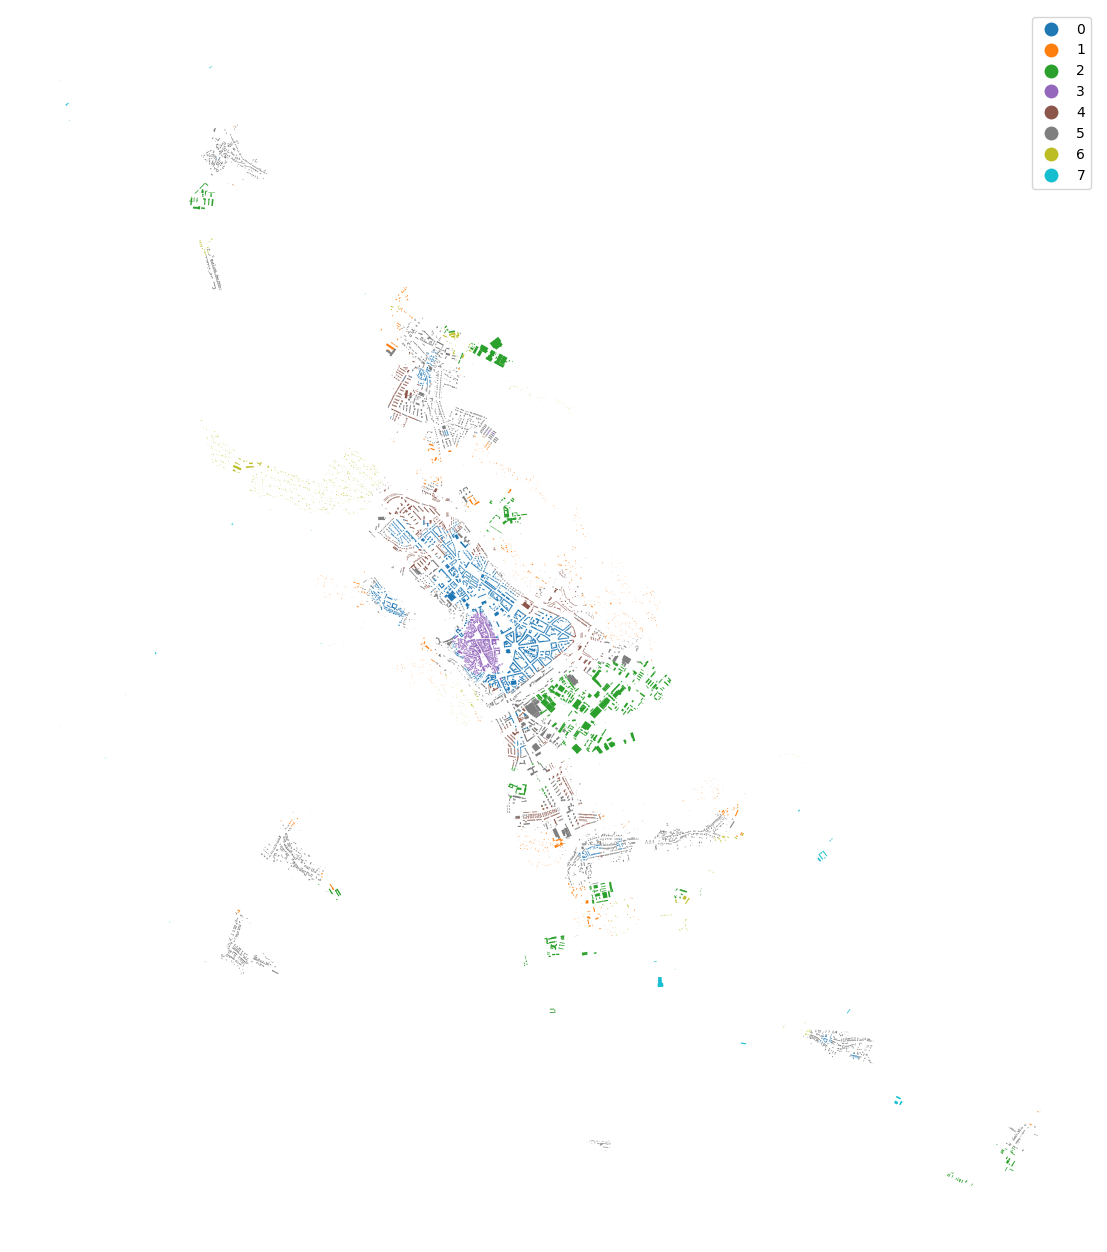

In [41]:
merged["cluster"] = cgram.labels[8].values
urban_types = buildings[["geometry", "uID"]].merge(merged[["uID", "cluster"]], on="uID")
urban_types.plot("cluster", categorical=True, figsize=(16, 16), legend=True).set_axis_off()

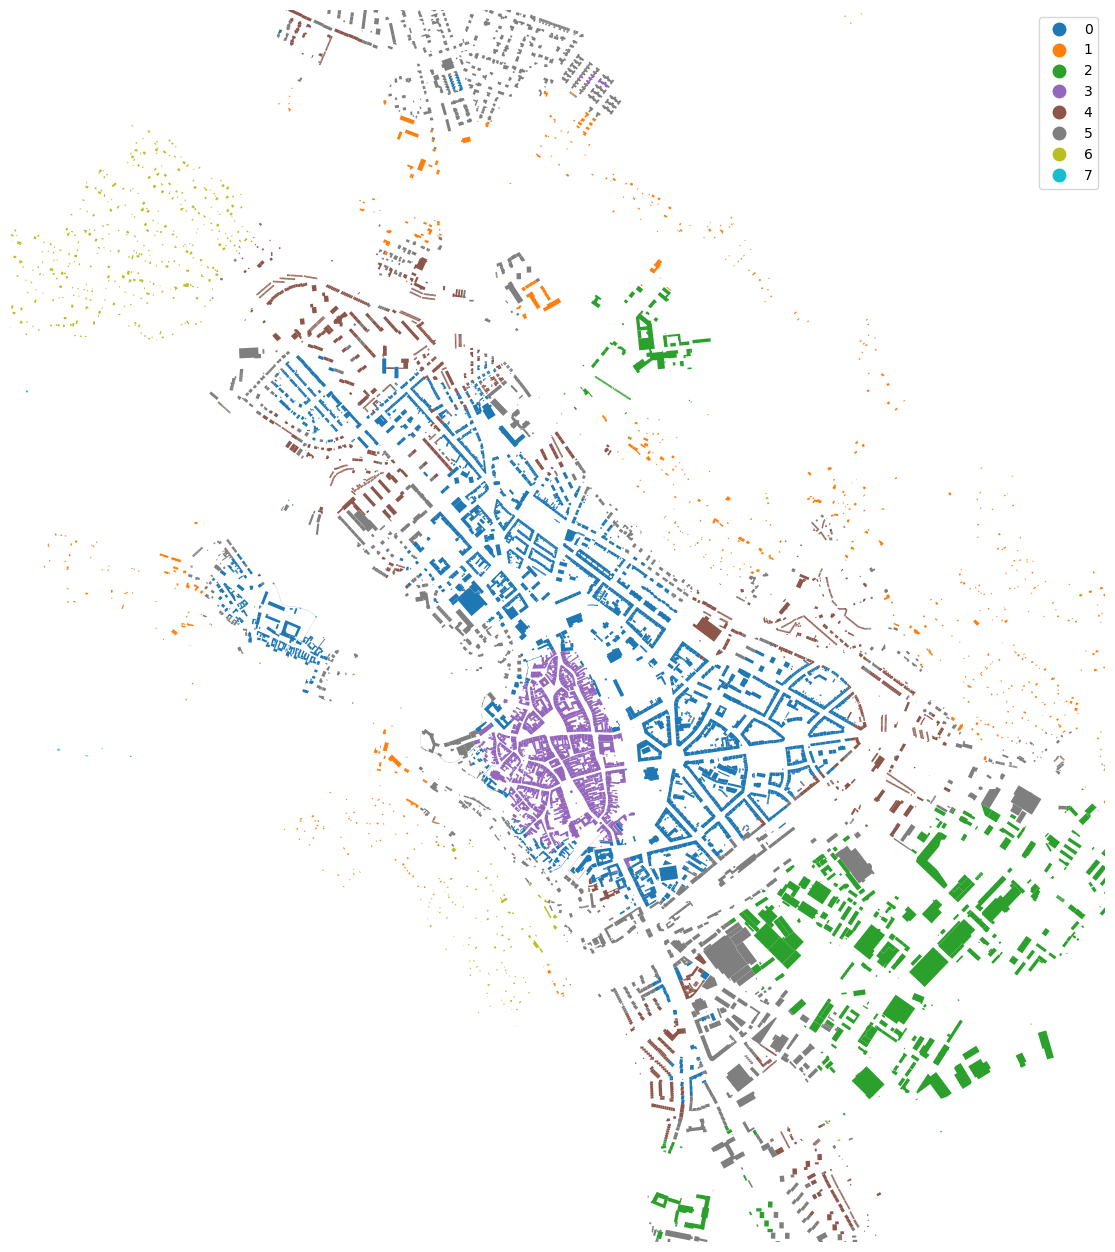

In [42]:
ax = urban_types.plot("cluster", categorical=True, figsize=(16, 16), legend=True)
ax.set_xlim(-645000, -641000)
ax.set_ylim(-1195500, -1191000)
ax.set_axis_off()